In [2]:
import json
from collections import Counter
import pandas as pd
import spacy

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

nlp = spacy.load('en')

from wordcloud import WordCloud, STOPWORDS
from itertools import chain

In [3]:
DATA_DIR = '/Users/ik/Data/spook/'

In [4]:
train_data = pd.read_csv(DATA_DIR + 'train.csv', dtype=str)

In [5]:
Counter(train_data.author)

Counter({'EAP': 7900, 'HPL': 5635, 'MWS': 6044})

### Edgar Allan Poe
* The Cask of Amontillado - http://www.gutenberg.org/ebooks/1063.txt.utf-8

* The Fall of the House of Usher - http://www.gutenberg.org/ebooks/932.txt.utf-8

* The Masque of the Red Death - http://www.gutenberg.org/ebooks/1064.txt.utf-8

* The Raven - http://www.gutenberg.org/ebooks/17192.txt.utf-8

* The Works of Edgar Allan Poe — Volume 1 - http://www.gutenberg.org/files/2147/2147-0.txt

* The Works of Edgar Allan Poe — Volume 2 - http://www.gutenberg.org/files/2148/2148-0.txt

In [6]:
train_data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [7]:
wc = WordCloud()

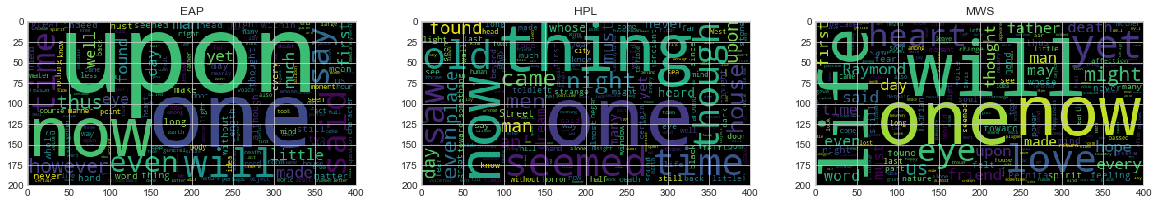

In [36]:
clouds = []
fig, axes = plt.subplots(1,3)
fig.set_size_inches(20,4)

for i, writer in enumerate(('EAP', 'HPL', 'MWS')):
    axes[i].imshow(wc.generate(" ".join([w for w in chain(train_data[train_data.author==writer].text)])))
    axes[i].set_title(writer)